In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import cv2
from pickle import dump, load
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense,BatchNormalization
import pickle as pk
from tensorflow.keras import applications

# Loading dataset

In [3]:
# loading saved training data
dataset_path = "/kaggle/input/pain-dataset/training_data_rgb_checkpoint.pkl"
if (os.path.exists(dataset_path)):
        training_data = load(open(dataset_path, 'rb'))

# Model building

In [4]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,Conv2D,MaxPooling2D, BatchNormalization
from tensorflow.keras import applications
from tensorflow import keras
from tensorflow.keras.applications import xception

In [5]:
def Model_vgg(ImgSize, fine_tune=0):
    pretrained_model = applications.vgg16.VGG16(weights='imagenet', include_top=False,input_shape=ImgSize)
    model = Sequential()
    
    for layer in pretrained_model.layers:
        model.add(layer)
    
    # freezing vgg16 layers
    if fine_tune > 0:
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    elif fine_tune == 'all':
        pass
    else:
        for layer in model.layers:
            layer.trainable = False
    
    # building dense layer
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [8]:
def Model_customized(fine_tune=0):
    conv_layer = xception.Xception(include_top=False, input_shape=(128, 128, 3))
    model = Sequential()

    model.add(conv_layer)
    
    # freezing vgg16 layers
    if fine_tune > 0:
        for layer in model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in model.layers:
            layer.trainable = False
    
    # building dense layer
    model.add(Flatten())
    model.add(Dense(1000,activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    
    model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return model

# Dataset preparation

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
RANDOM_STATE = 23

def train_test_split_(dataset_path, test_size=None):
    #loading saved dataset
    if (os.path.exists(dataset_path)):
        training_data = load(open(dataset_path, 'rb'))
    
    x = np.array([img for img, label in training_data])
    y = np.array([label for img, label in training_data])
    
    if test_size:
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=test_size, random_state=RANDOM_STATE)
    else:
        x_train, y_train = x, y
        x_test, y_test = None, None

    return (x_train, y_train), (x_test, y_test)

In [8]:
(x_train, y_train), (x_test, y_test) = train_test_split_("/kaggle/input/pain-dataset/training_data_rgb.pkl", test_size=0.2)

In [9]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1]), array([6798, 6674])), (array([0, 1]), array([1673, 1695])))

In [13]:
# data_generator = ImageDataGenerator(
#     horizontal_flip=True
# )

# batch_size = 64
# data_generator.fit(x_train)

# train_gen = data_generator.flow(x_train, y_train, batch_size=batch_size, seed=RANDOM_STATE)
# del x_train
# del y_train
# del training_data

# Model Training

In [10]:
def plot_history(hist):
    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc='upper left')
    plt.show()

In [45]:
model = Model_vgg((128, 128, 3))

In [46]:
# !mkdir "logs/"
# !mkdir "checkpoints/"

In [16]:
# creating logs
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


LOG_NAME = "logs/vgg16_1"
# !mkdir "logs/"
tensorboard = TensorBoard(log_dir=LOG_NAME)

# checkpoints
CHECKPOINT_NAME = "checkpoints/checkpoint_e{epoch:02d}_Va{val_accuracy:.02f}.h5"
checkpoint = ModelCheckpoint(CHECKPOINT_NAME, monitor='val_accuracy',
                             verbose=1, save_best_only=True,
                            mode='max')

2022-12-11 06:24:40.774655: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 06:24:40.774718: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-11 06:24:40.781352: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-11 06:24:41.218416: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-11 06:24:41.218611: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
hist = model.fit(x_train, y_train, epochs=15, verbose=1, validation_split=0.2, callbacks=[tensorboard, checkpoint])

2022-12-11 05:33:04.477968: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 521453568 exceeds 10% of free system memory.
2022-12-11 05:33:05.099010: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 521453568 exceeds 10% of free system memory.
2022-12-11 05:33:05.562468: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-11 05:33:08.292759: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/332 [..............................] - ETA: 1:21:21 - loss: 0.7770 - accuracy: 0.5000

2022-12-11 05:33:20.435237: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 05:33:20.435282: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/332 [..............................] - ETA: 4:04 - loss: 1.0293 - accuracy: 0.4062   

2022-12-11 05:33:21.149611: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-11 05:33:21.150778: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-11 05:33:21.308291: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 219 callback api events and 216 activity events. 
2022-12-11 05:33:21.321360: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  5/332 [..............................] - ETA: 1:30 - loss: 0.8722 - accuracy: 0.4750

2022-12-11 05:33:21.355946: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_05_33_21

2022-12-11 05:33:21.362544: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_11_05_33_21/44b8c2c3c9c2.trace.json.gz
2022-12-11 05:33:21.396073: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_05_33_21

2022-12-11 05:33:21.398271: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_11_05_33_21/44b8c2c3c9c2.memory_profile.json.gz
2022-12-11 05:33:21.398977: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_05_33_21
Dumped tool data for xplane.pb to logs/vgg16_1/train/plugins/

332/332 [==============================] - 41s 79ms/step - loss: 0.7186 - accuracy: 0.5430 - val_loss: 0.6525 - val_accuracy: 0.7216

Epoch 00001: val_accuracy improved from -inf to 0.72157, saving model to checkpoints/checkpoint_e01_Va0.72.h5
Epoch 2/15
332/332 [==============================] - 23s 70ms/step - loss: 0.5922 - accuracy: 0.6929 - val_loss: 0.4965 - val_accuracy: 0.7596

Epoch 00002: val_accuracy improved from 0.72157 to 0.75962, saving model to checkpoints/checkpoint_e02_Va0.76.h5
Epoch 3/15
332/332 [==============================] - 24s 71ms/step - loss: 0.4913 - accuracy: 0.7690 - val_loss: 0.4352 - val_accuracy: 0.7827

Epoch 00003: val_accuracy improved from 0.75962 to 0.78271, saving model to checkpoints/checkpoint_e03_Va0.78.h5
Epoch 4/15
332/332 [==============================] - 24s 72ms/step - loss: 0.4493 - accuracy: 0.7845 - val_loss: 0.4153 - val_accuracy: 0.7917

Epoch 00004: val_accuracy improved from 0.78271 to 0.79173, saving model to checkpoints/checkpo

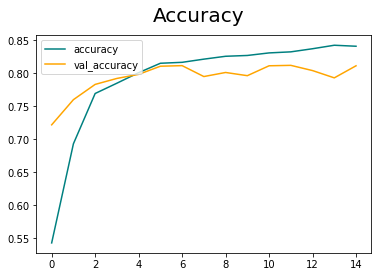

In [18]:
plot_history(hist)

In [ ]:
hist = model.fit(x_train, y_train, epochs=15, verbose=1, validation_split=0.3)

In [ ]:
plot_history(hist)

In [ ]:
hist = model.fit(x_train, y_train, epochs=15, verbose=1, validation_split=0.3)

# Download logs and checkpoints

In [20]:
# zip and download the logs
# !zip -r file_logs.zip /kaggle/working/logs
!zip -r file_checkpoints.zip /kaggle/working/checkpoints

# use below command to open the tensorboard
# !tensorboard --logdir=logs/

updating: kaggle/working/checkpoints/ (stored 0%)
updating: kaggle/working/checkpoints/checkpoint_e05_Va0.80.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e01_Va0.72.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e07_Va0.81.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e06_Va0.81.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e04_Va0.79.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e02_Va0.76.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e03_Va0.78.h5 (deflated 7%)
updating: kaggle/working/checkpoints/checkpoint_e12_Va0.81.h5 (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint_e01_Va0.82.h5 (deflated 7%)
  adding: kaggle/working/checkpoints/checkpoint_e06_Va0.83.h5 (deflated 7%)


# Fine Tunning Model

In [40]:
# model = keras.load("")

AttributeError: 'Sequential' object has no attribute 'copy'

In [37]:
model.trainable = True

In [38]:
assert model.layers[0].trainable == True
model.layers[0]

In [39]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.optimizer = opt

In [36]:
# model.run_eagerly = True

In [43]:
hist = model.fit( train_gen, 
                epochs=15,  # one forward/backward pass of training data
                steps_per_epoch=x_train_shape//batch_size,  # number of images comprising of one epoch
                validation_data=(x_test, y_test), # Or validation_data=valid_generator
                validation_steps=x_test_shape//batch_size,
                callbacks=[tensorboard, checkpoint])

Epoch 1/15


FailedPreconditionError:  Could not find variable _AnonymousVar49. This could mean that the variable has been deleted. In TF1, it can also mean the variable is uninitialized. Debug info: container=localhost, status=Not found: Resource localhost/_AnonymousVar49/N10tensorflow3VarE does not exist.
	 [[node Adam/ReadVariableOp (defined at tmp/ipykernel_1557/2529769680.py:5) ]] [Op:__inference_train_function_2009]

Function call stack:
train_function


# Model prediction

In [19]:
y_pred = model.predict(x_test)
y_pred

array([[8.71175110e-01, 1.28824830e-01],
       [3.93380821e-01, 6.06619179e-01],
       [6.60531640e-01, 3.39468300e-01],
       ...,
       [1.10652116e-04, 9.99889374e-01],
       [5.25968134e-01, 4.74031866e-01],
       [4.02314156e-01, 5.97685814e-01]], dtype=float32)

In [21]:
np.argmax(y_pred, axis=1)

array([0, 1, 0, ..., 1, 0, 1])

In [22]:
np.unique(y_test == np.argmax(y_pred,axis=1), return_counts=True)

(array([False,  True]), array([ 623, 2745]))

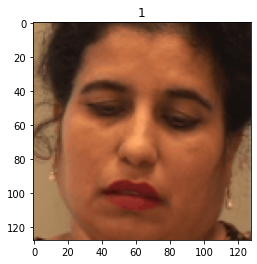

In [23]:
index = -1
img, label = x_test[index], y_test[index]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(label)
plt.show()

In [28]:
img, label = training_data[3000]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(label)
plt.show()

NameError: name 'training_data' is not defined

In [29]:
def predict(image):
    IMG_SHAPE = 128
    
    # detect face in the image
    harrcascade_face_xml = "/kaggle/input/haarcascades/haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(harrcascade_face_xml)
    
    img_data_gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(img_data_gray, 1.1, 4)
    
    if not len(faces):
        print("no face detected")
        return
                    
    x, y, w, h = faces[0]
    face_cropped = image[y: y+h, x: x+w]
    img_data = cv2.resize(face_cropped, (IMG_SHAPE, IMG_SHAPE))
    return np.argmax(model.predict(img_data.reshape(-1, IMG_SHAPE, IMG_SHAPE, 3)), axis=1)
    

In [ ]:
img, label = training_data[3000]
predict(img), label

In [34]:
!wget "https://www.universityofcalifornia.edu/sites/default/files/styles/article_default_banner/public/child_in_pain.jpg"

--2022-12-11 06:52:07--  https://www.universityofcalifornia.edu/sites/default/files/styles/article_default_banner/public/child_in_pain.jpg
Resolving www.universityofcalifornia.edu (www.universityofcalifornia.edu)... 23.185.0.2, 2620:12a:8001::2, 2620:12a:8000::2
Connecting to www.universityofcalifornia.edu (www.universityofcalifornia.edu)|23.185.0.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87956 (86K) [image/jpeg]
Saving to: ‘child_in_pain.jpg’

child_in_pain.jpg   100%[===================>]  85.89K  --.-KB/s    in 0.01s   

2022-12-11 06:52:07 (5.73 MB/s) - ‘child_in_pain.jpg’ saved [87956/87956]



In [35]:
image = cv2.imread("/kaggle/working/child_in_pain.jpg")
predict(image)

array([0])

In [ ]:
model.save("/kaggle/working/model_acc_87_79.h5")

# USING DATAGENERATOR FOR AUGMENTATION

In [11]:
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    rescale=1.1,
    rotation_range= 10 #-10 degree - 10 degree
)

batch_size = 64
data_generator.fit(x_train)

train_gen = data_generator.flow(x_train, y_train, batch_size=batch_size, seed=RANDOM_STATE)

x_train_shape = x_train.shape[0]
x_test_shape = x_test.shape[0]

del x_train
del y_train
del training_data

In [12]:
model = Model_vgg((128, 128, 3))

2022-12-11 06:04:42.034575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 06:04:42.035541: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 06:04:42.320782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 06:04:42.321684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 06:04:42.322508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [13]:
hist = model.fit_generator(train_gen, 
                    epochs=15,  # one forward/backward pass of training data
                    steps_per_epoch=x_train_shape//batch_size,  # number of images comprising of one epoch
                    validation_data=(x_test, y_test), # Or validation_data=valid_generator
                    validation_steps=x_test_shape//batch_size)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-11 06:04:54.697513: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-11 06:04:57.635864: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


210/210 [==============================] - 84s 324ms/step - loss: 0.6384 - accuracy: 0.6379 - val_loss: 0.4752 - val_accuracy: 0.7886
Epoch 2/15
210/210 [==============================] - 58s 276ms/step - loss: 0.5056 - accuracy: 0.7528 - val_loss: 0.4215 - val_accuracy: 0.7996
Epoch 3/15
210/210 [==============================] - 58s 274ms/step - loss: 0.4612 - accuracy: 0.7763 - val_loss: 0.3925 - val_accuracy: 0.8094
Epoch 4/15
210/210 [==============================] - 57s 273ms/step - loss: 0.4241 - accuracy: 0.7895 - val_loss: 0.3964 - val_accuracy: 0.8204
Epoch 5/15
210/210 [==============================] - 57s 271ms/step - loss: 0.4164 - accuracy: 0.7949 - val_loss: 0.3933 - val_accuracy: 0.8109
Epoch 6/15
210/210 [==============================] - 58s 274ms/step - loss: 0.3994 - accuracy: 0.8037 - val_loss: 0.3958 - val_accuracy: 0.8210
Epoch 7/15
210/210 [==============================] - 57s 272ms/step - loss: 0.3844 - accuracy: 0.8091 - val_loss: 0.3865 - val_accuracy: 0.8

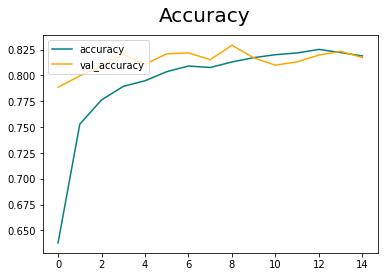

In [14]:
plot_history(hist)

In [17]:
hist = model.fit(train_gen,
                 epochs=15,  # one forward/backward pass of training data
                 steps_per_epoch=x_train_shape//batch_size,  # number of images comprising of one epoch
                 validation_data=(x_test, y_test), # Or validation_data=valid_generator
                 validation_steps=x_test_shape//batch_size,
                 callbacks=[tensorboard, checkpoint])

Epoch 1/15
  1/210 [..............................] - ETA: 1:13 - loss: 0.3250 - accuracy: 0.8281

2022-12-11 06:24:52.690643: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 06:24:52.690695: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/210 [..............................] - ETA: 1:39 - loss: 0.3261 - accuracy: 0.8359

2022-12-11 06:24:53.135773: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-11 06:24:53.136560: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-11 06:24:53.303693: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 218 callback api events and 215 activity events. 
2022-12-11 06:24:53.315928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


  3/210 [..............................] - ETA: 1:26 - loss: 0.3447 - accuracy: 0.8177

2022-12-11 06:24:53.349236: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_06_24_53

2022-12-11 06:24:53.354248: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_11_06_24_53/44b8c2c3c9c2.trace.json.gz
2022-12-11 06:24:53.389169: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_06_24_53

2022-12-11 06:24:53.391303: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/vgg16_1/train/plugins/profile/2022_12_11_06_24_53/44b8c2c3c9c2.memory_profile.json.gz
2022-12-11 06:24:53.392016: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/vgg16_1/train/plugins/profile/2022_12_11_06_24_53
Dumped tool data for xplane.pb to logs/vgg16_1/train/plugins/

210/210 [==============================] - 58s 277ms/step - loss: 0.3604 - accuracy: 0.8191 - val_loss: 0.3753 - val_accuracy: 0.8239

Epoch 00001: val_accuracy improved from -inf to 0.82393, saving model to checkpoints/checkpoint_e01_Va0.82.h5
Epoch 2/15
210/210 [==============================] - 58s 274ms/step - loss: 0.3557 - accuracy: 0.8243 - val_loss: 0.3879 - val_accuracy: 0.8171

Epoch 00002: val_accuracy did not improve from 0.82393
Epoch 3/15
210/210 [==============================] - 56s 266ms/step - loss: 0.3509 - accuracy: 0.8221 - val_loss: 0.3804 - val_accuracy: 0.8201

Epoch 00003: val_accuracy did not improve from 0.82393
Epoch 4/15
210/210 [==============================] - 57s 271ms/step - loss: 0.3512 - accuracy: 0.8276 - val_loss: 0.3782 - val_accuracy: 0.8207

Epoch 00004: val_accuracy did not improve from 0.82393
Epoch 5/15
210/210 [==============================] - 57s 271ms/step - loss: 0.3513 - accuracy: 0.8247 - val_loss: 0.3728 - val_accuracy: 0.8221

Epoch 

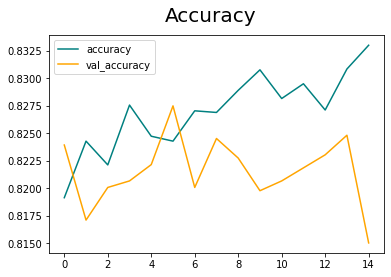

In [18]:
plot_history(hist)

In [36]:
model.save("new")